# Introduction to Machine Learning
## Project Phase 1

Sina Fathi | 402111261

Seyyed Amirmahdi Sadrzadeh | 401102015

### Part 1: Data Preproccessing

First we import the needed libraries:

In [55]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

Now we use torch library to load the MNIST dataset and then turn them to numpy arrays:

In [56]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)

X_train_torch = trainset.data
Y_train_torch = trainset.targets

X_train = X_train_torch.numpy()
Y_train = Y_train_torch.numpy()

To use the datas, we binarize them by setting a threshold equal to 128. So all pixels with values higher than 128 will be set to 1 and others will be set to 0. We also flatten the datas to use them in our model:

In [57]:
threshold = 128
X_train = (X_train > threshold).astype(np.uint32)
X_train_binary = X_train.reshape(-1, 28 * 28)

The plot to show the samples:

In [58]:
def show_samples(samples, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].reshape(28, 28), cmap='binary')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

And now we use the above function to show 10 samples from the dataset:

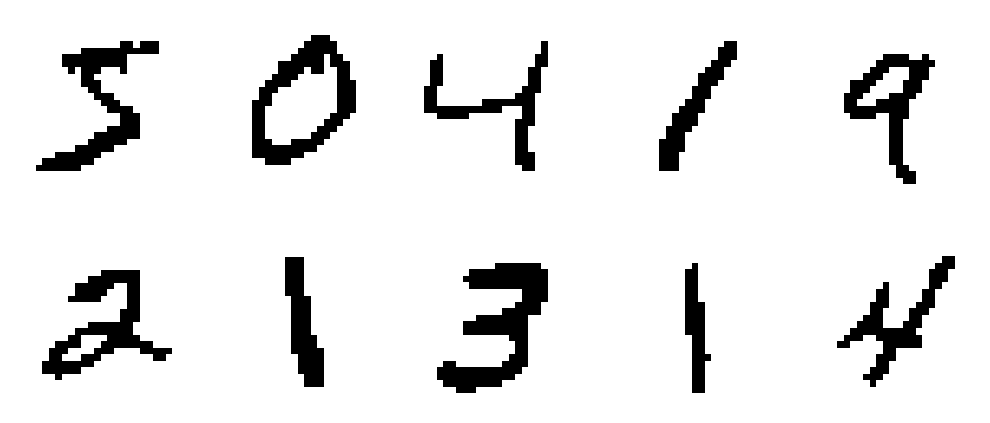

In [59]:
show_samples(X_train_binary[:10])

### Part 2: Implementing the model

To implement the RBM class, we initialize the values of the model parameters by setting the number of layers, the learning rate , and weights and biases. We set the initial values of biases to zero and set the initial values of the weights to a small value using gaussian distribution.

For the contstrative divergence, we use the algorythm in the theory part and implement the method accordingly.

The other part are like the classes we have implemented before.

You can see the RBM class below:

In [66]:
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.W = np.random.normal(0, 0.1, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        return (np.random.uniform(size=prob.shape) < prob).astype(np.int32)

    def gibbs_sampling(self, hid, k):
        v_prob_0 = self.sigmoid(np.dot(hid, self.W.T) + self.v_bias)
        v = self.sample(v_prob_0)
        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v, self.W) + self.h_bias)
            h_sample = self.sample(h_prob)
            v_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v = self.sample(v_prob)
        return v

    def contrastive_divergence(self, v, k):

      h_prob_0 = self.sigmoid(np.dot(v, self.W) + self.h_bias)
      h_sample_0 = self.sample(h_prob_0)

      v_neg = v.copy()

      for _ in range(k):
          h_prob = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)
          h_sample = self.sample(h_prob)
          v_prob_neg = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
          v_neg = self.sample(v_prob_neg)

      h_prob_neg = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)

      positive_grad = np.dot(v.T, h_prob_0)
      negative_grad = np.dot(v_neg.T, h_prob)

      batch_size = v.shape[0]
      self.W += self.learning_rate * (positive_grad - negative_grad) / batch_size
      self.v_bias += self.learning_rate * np.mean(v - v_neg, axis=0)
      self.h_bias += self.learning_rate * np.mean(h_prob_0 - h_prob_neg, axis=0)

      return v_neg


    def train(self, data, epochs=10, k=1, batch_size=64):
        for epoch in range(epochs):
            np.random.shuffle(data)
            epoch_loss = 0
            for batch_start in range(0, len(data), batch_size):
                batch = data[batch_start:batch_start + batch_size]
                v_neg = self.contrastive_divergence(batch, k)
                epoch_loss += np.mean((batch - v_neg) ** 2)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(data):.5f}")

    def generate_samples(self, n_samples=10, k=1):
        samples = []
        for i in range(n_samples):
          sample = np.random.binomial(1, 0.5, self.n_hidden)
          sample = self.gibbs_sampling(sample, k)
          samples.append(sample)
        return np.array(samples)

Now that we have completely implemented the class, we use the code below to train the model.

You can see the loss of each epoch and how the model converges for different values of k (1, 5, 10).

In [67]:
n_visible = X_train_binary.shape[1]
n_hidden = 32
k_values = [1, 5, 10]
rbms = {}

for k in k_values:
    print(f"Training RBM with k={k}")
    rbm = RBM(n_visible, n_hidden)
    rbm.train(X_train_binary, epochs=10, k=k)
    rbms[k] = rbm

Training RBM with k=1
Epoch 1/10, Loss: 0.00262
Epoch 2/10, Loss: 0.00194
Epoch 3/10, Loss: 0.00184
Epoch 4/10, Loss: 0.00180
Epoch 5/10, Loss: 0.00178
Epoch 6/10, Loss: 0.00178
Epoch 7/10, Loss: 0.00177
Epoch 8/10, Loss: 0.00177
Epoch 9/10, Loss: 0.00177
Epoch 10/10, Loss: 0.00178
Training RBM with k=5
Epoch 1/10, Loss: 0.00217
Epoch 2/10, Loss: 0.00170
Epoch 3/10, Loss: 0.00160
Epoch 4/10, Loss: 0.00155
Epoch 5/10, Loss: 0.00152
Epoch 6/10, Loss: 0.00150
Epoch 7/10, Loss: 0.00148
Epoch 8/10, Loss: 0.00147
Epoch 9/10, Loss: 0.00146
Epoch 10/10, Loss: 0.00146
Training RBM with k=10
Epoch 1/10, Loss: 0.00226
Epoch 2/10, Loss: 0.00177
Epoch 3/10, Loss: 0.00167
Epoch 4/10, Loss: 0.00162
Epoch 5/10, Loss: 0.00158
Epoch 6/10, Loss: 0.00156
Epoch 7/10, Loss: 0.00155
Epoch 8/10, Loss: 0.00153
Epoch 9/10, Loss: 0.00152
Epoch 10/10, Loss: 0.00151


By trying different parameters, we reach the above configurations. Now to see the generated samples of this model, we use the function below:

In [68]:
def show_generated_samples(rbm, k, n_samples=10):
    print(f"Generated samples for k={k}")
    samples = rbm.generate_samples(n_samples, k=k)
    samples = samples.reshape((-1, 28, 28))
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i], cmap='binary')
        ax.axis('off')
    plt.show()

Generated samples for k=1


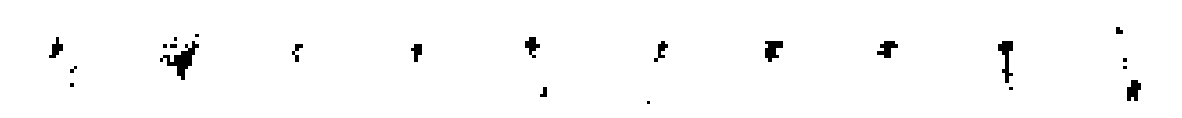

Generated samples for k=5


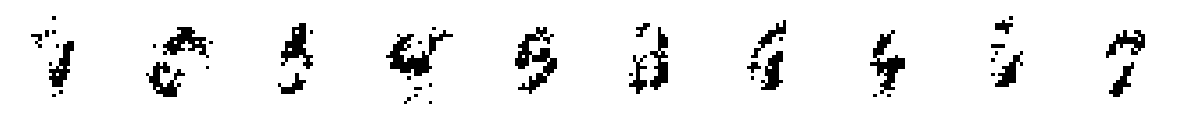

Generated samples for k=10


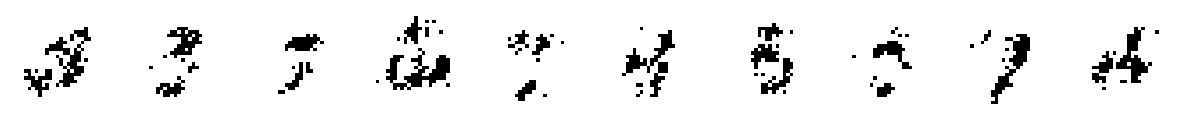

In [70]:
for k in k_values:
    show_generated_samples(rbms[k],k)

We can see that by increasing the value of k, the numbers generated get better but the difference between k=1 and k=5 is more obvious than the difference between k=5 and k=10.

### Part 3: Showing the sampling proccess


To visualize the steps in the MCMC proccess, we define the function below to keep tracj of the steps in our model.

And we use it to show the steps in the model with k=10.

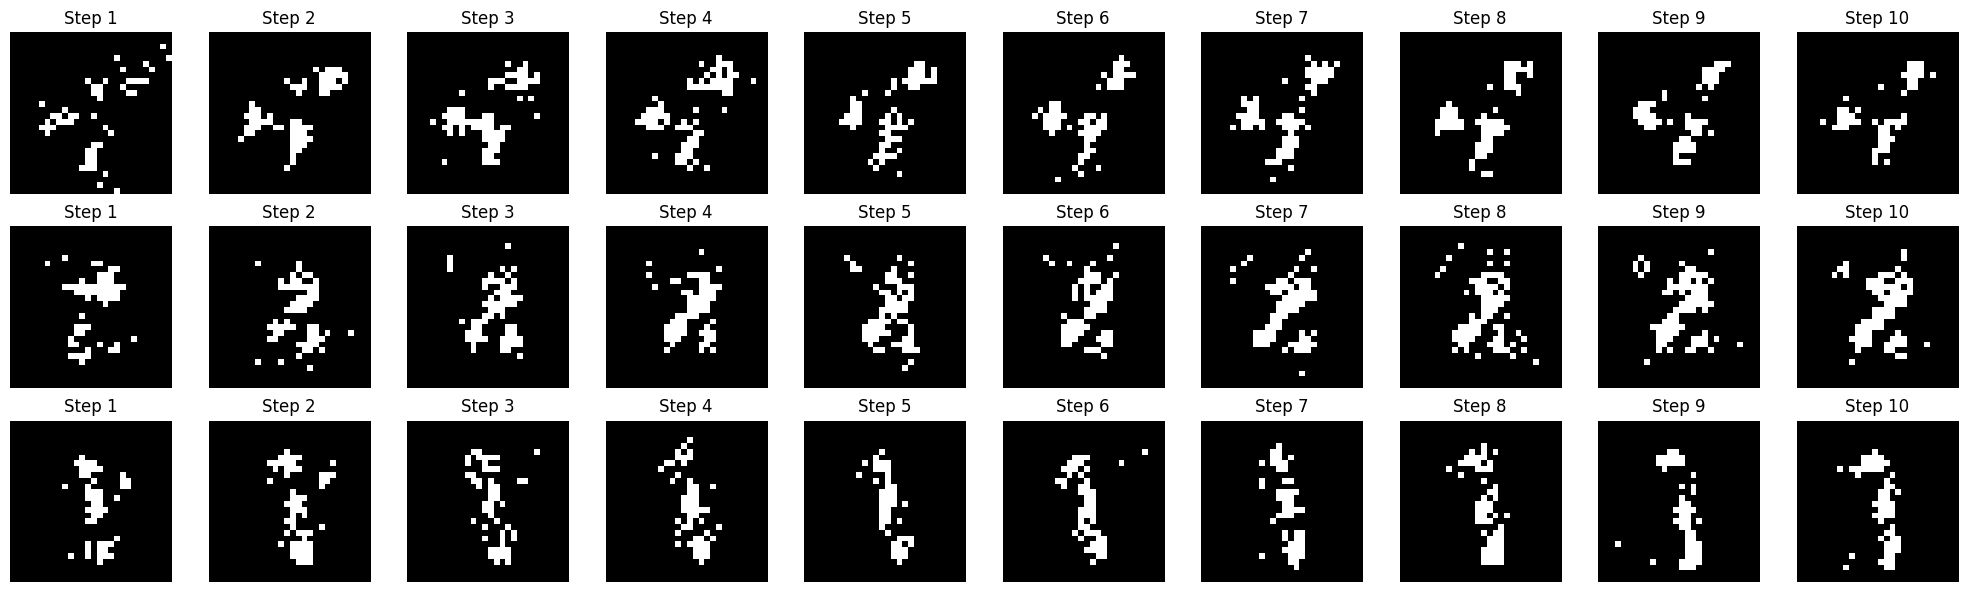

In [71]:
def visualize_mcmc_trained_model(rbm, n_samples=3, track_steps=5):

    fig, axes = plt.subplots(n_samples, track_steps, figsize=(track_steps * 2, n_samples * 2))

    for i in range(n_samples):
        h_sample = np.random.binomial(1, 0.5, rbm.n_hidden)
        states = []

        for step in range(track_steps):
            v_prob = rbm.sigmoid(np.dot(h_sample, rbm.W.T) + rbm.v_bias)
            v_sample = rbm.sample(v_prob)
            states.append(v_sample)
            h_prob = rbm.sigmoid(np.dot(v_sample, rbm.W) + rbm.h_bias)
            h_sample = rbm.sample(h_prob)

        for j, state in enumerate(states):
            ax = axes[i, j] if n_samples > 1 else axes[j]
            ax.imshow(state.reshape(28, 28), cmap="gray")
            ax.axis("off")
            ax.set_title(f"Step {j + 1}")

    plt.tight_layout()
    plt.show()

visualize_mcmc_trained_model(rbms[10], n_samples=3, track_steps=10)

As you can see, the numbers are getting closer and closer to the final values. For example, in the last columns of the pictures above, you can guess that the first number is 4, the second one is 2 and the last one is 1. But in the first columns, the numbers aren't clear enough. (If you run the code block you get different numbers)

Also, as we mentioned before, you can see that the difference between each step is becoming less in the higher steps.

### Part 4: Control over the produced samples

In order to genrate a specific number, we will follow the steps below:

**First, we need to obtain the feataure vector for the needed number.** To do this, we use the training dataset to compute an average feature vector for our digit. This acts as a "template" for the number we want.

**Second, we have to put a condition on the hidden layer.** For this, we use the feature vector corresponding to the desired number to bias the hidden layer activations.

**And at last, we can generate the samples.** We perform Gibbs sampling, starting from the biased hidden layer to generate visible states corresponding to the desired digit.

In a more simple way, we are obtaining the hidden layer structure by putting the samples from the desired number to the visible layer and then, by giving this hidden layer structure as the input to our gibbs sampling function, we can obtain the number we were looking for.

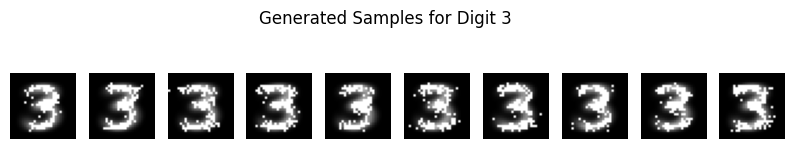

In [72]:
def generate_specific_digit(rbm, digit, data, labels, num_samples=10, k=10):
    digit_data = data[labels == digit]
    digit_data = (digit_data > 128).astype(np.uint32)
    data_binary = digit_data.reshape(-1, 28 * 28)
    mean_representation = np.mean(data_binary, axis=0)

    generated_samples = []
    for _ in range(num_samples):
        v = mean_representation.copy()

        for _ in range(k):
            h_prob = rbm.sigmoid(np.dot(v, rbm.W) + rbm.h_bias)
            h_sample = rbm.sample(h_prob)
            v_prob = rbm.sigmoid(np.dot(h_sample, rbm.W.T) + rbm.v_bias)
            visible_sample = rbm.sample(v_prob)
            visible_layer = mean_representation.copy()
            visible_layer[visible_sample > 0.5] = visible_sample[visible_sample > 0.5]

        generated_samples.append(visible_layer.reshape(28, 28))

    return generated_samples

X_train_torch = trainset.data
Y_train_torch = trainset.targets
X_train = X_train_torch.numpy()
Y_train = Y_train_torch.numpy()

digit_to_generate = 3
controlled_samples = generate_specific_digit(rbms[10], digit_to_generate, X_train, Y_train, num_samples=10)

def display_controlled_samples(samples):
    plt.figure(figsize=(10, 2))
    for i, sample in enumerate(samples):
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(sample, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Generated Samples for Digit {digit_to_generate}")
    plt.show()

display_controlled_samples(controlled_samples)


You can see that we get a much better result in this section. This is because we are now solving a supervised learning problem unlike the previous part. By having the labels for the inputs, we can train the model better and get a better result and better approximation for our weights and biases.